# Import Packages

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sklearn
import scipy
import seaborn as sns


# Load libraries

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)

# Import GaussianNB
from sklearn.naive_bayes import GaussianNB


# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import  make_pipeline

# For standardization
from sklearn.preprocessing  import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Classification metrics (added later)
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import GridSearchCV


# Load Data

In [2]:
df = pd.read_json('logins.json')
df2 = pd.read_json('ultimate_data_challenge.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


# Part 1 ‐ Exploratory data analysis

In [4]:
data = df['login_time'].value_counts()
data = data.resample(rule='15T').sum()
data = pd.DataFrame(data)
data.head()

,login_time
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


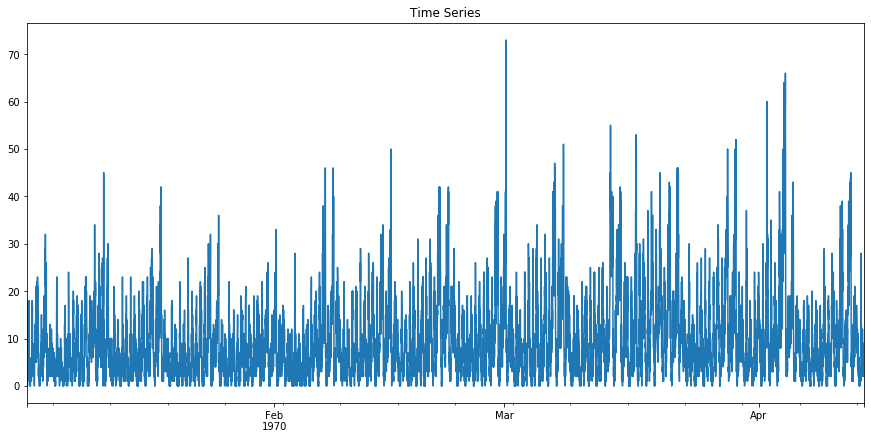

In [5]:
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, title="Time Series", legend=False)

If we plot the whole data, it is all cramped together. Let's try trimming the data.

## Plot by month

1 = January

2 = February

3 = March

4 = April

In [6]:
# We'll create columns for that split our timestamp into year, month, and day

data_df = pd.DataFrame(data)

data_df['new_date'] = [d.date() for d in data.index]
data_df['new_time'] = [d.time() for d in data.index]
data_df = data.reset_index()
# data_df.head()
data_df

data_df['YEAR'] = data_df['index'].dt.year
data_df['MONTH'] = data_df['index'].dt.month
data_df['DAY'] = data_df['index'].dt.day
data_df

,index,login_time,new_date,new_time,YEAR,MONTH,DAY
0,1970-01-01 20:00:00,2,1970-01-01,20:00:00,1970,1,1
1,1970-01-01 20:15:00,6,1970-01-01,20:15:00,1970,1,1
2,1970-01-01 20:30:00,9,1970-01-01,20:30:00,1970,1,1
3,1970-01-01 20:45:00,7,1970-01-01,20:45:00,1970,1,1
4,1970-01-01 21:00:00,1,1970-01-01,21:00:00,1970,1,1
...,...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,1970-04-13,17:45:00,1970,4,13
9784,1970-04-13 18:00:00,5,1970-04-13,18:00:00,1970,4,13
9785,1970-04-13 18:15:00,2,1970-04-13,18:15:00,1970,4,13
9786,1970-04-13 18:30:00,7,1970-04-13,18:30:00,1970,4,13


In [7]:
# We will have to create a pivot table where index is the 15-min interval and columns are the month

pv = pd.pivot_table(data_df, index=data_df['new_time'], columns=data_df['MONTH'],
                    values='login_time', aggfunc='sum')
pv

MONTH,1,2,3,4
new_time,,,,
00:00:00,313,361,553,212
00:15:00,361,412,551,223
00:30:00,339,388,537,261
00:45:00,372,347,519,244
01:00:00,343,411,553,242
...,...,...,...,...
22:45:00,362,452,597,226
23:00:00,350,484,540,199
23:15:00,311,444,591,206


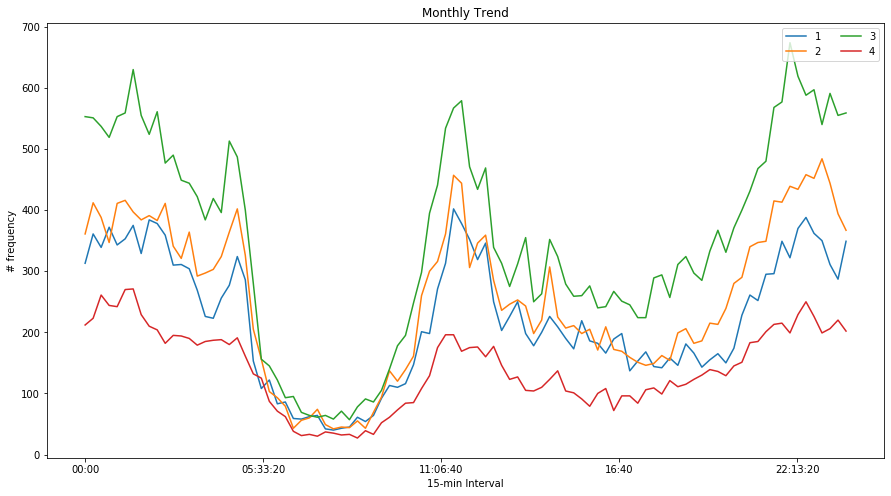

In [8]:
# Plot the df
fig, ax = plt.subplots(figsize=(15,8))
pv.plot(ax=ax, title="Monthly Trend", legend=False)
ax.set(xlabel="15-min Interval", ylabel="# frequency")

# Customize Legend
ax.legend(loc='upper right', frameon=True, ncol=2)


### The trend follows throughout the entire 24-hour but the frequency decreses as month progresses.

## Plot the first 2 weeks of data

Monday-Sunday

### We'll plot the first week of data

In [9]:
firstweek = data['1970-01-05':'1970-01-11']
firstweek = pd.DataFrame(firstweek)
firstweek

,login_time,new_date,new_time
1970-01-05 00:00:00,8,1970-01-05,00:00:00
1970-01-05 00:15:00,3,1970-01-05,00:15:00
1970-01-05 00:30:00,7,1970-01-05,00:30:00
1970-01-05 00:45:00,4,1970-01-05,00:45:00
1970-01-05 01:00:00,7,1970-01-05,01:00:00
...,...,...,...
1970-01-11 22:45:00,6,1970-01-11,22:45:00
1970-01-11 23:00:00,2,1970-01-11,23:00:00
1970-01-11 23:15:00,6,1970-01-11,23:15:00
1970-01-11 23:30:00,8,1970-01-11,23:30:00


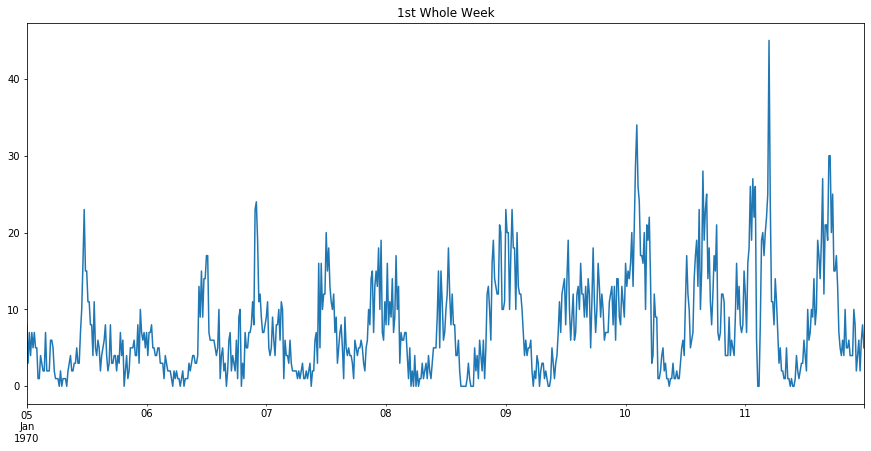

In [92]:
fig, ax = plt.subplots(figsize=(15,7))
firstweek.plot(ax=ax, title="1st Whole Week", legend=False)

### We'll plot the second week of data

In [11]:
secweek = data['1970-01-12':'1970-01-18']
secweek = pd.DataFrame(secweek)
secweek.head()


,login_time,new_date,new_time
1970-01-12 00:00:00,4,1970-01-12,00:00:00
1970-01-12 00:15:00,10,1970-01-12,00:15:00
1970-01-12 00:30:00,7,1970-01-12,00:30:00
1970-01-12 00:45:00,7,1970-01-12,00:45:00
1970-01-12 01:00:00,5,1970-01-12,01:00:00


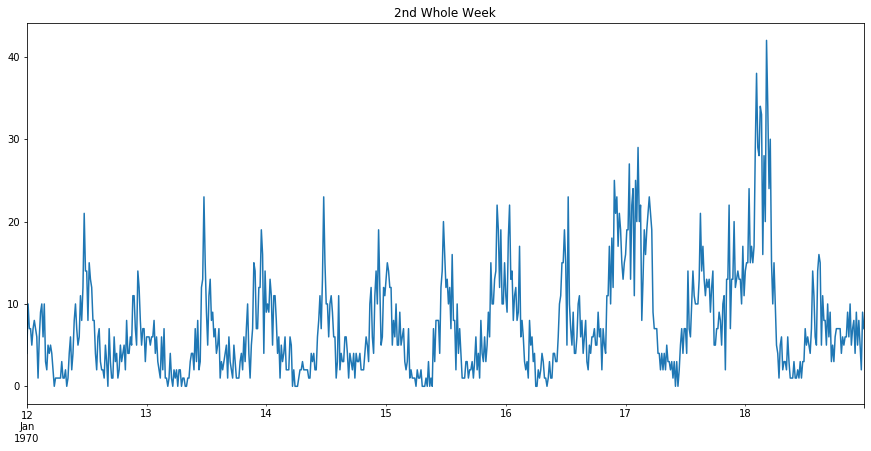

In [93]:
fig, ax = plt.subplots(figsize=(15,7))
secweek.plot(ax=ax, title="2nd Whole Week", legend=False)

### We are seeing the same trend for both weeks. Let's try plotting per day to see the difference each day.

In [13]:
firstweek_ = firstweek.set_index(['new_time', 'new_date']).unstack()

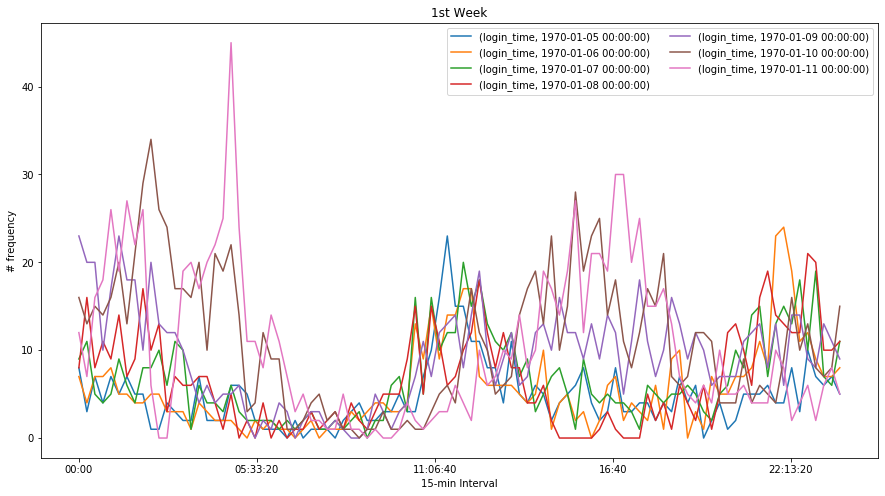

In [14]:
# Plot the df
fig, ax = plt.subplots(figsize=(15,8))
firstweek_.plot(ax=ax, title="1st Week", legend=False)
ax.set(xlabel="15-min Interval", ylabel="# frequency")

# Customize Legend
ax.legend(loc='upper right', frameon=True, ncol=2)

#### It looks like the data for weekdays (01-05-1970 to 01-09-1970) have almost the same trend except for the weekends (01-10-1970 to 01-11-1970). Let's compare it to the following week to check if it follows the same trend.

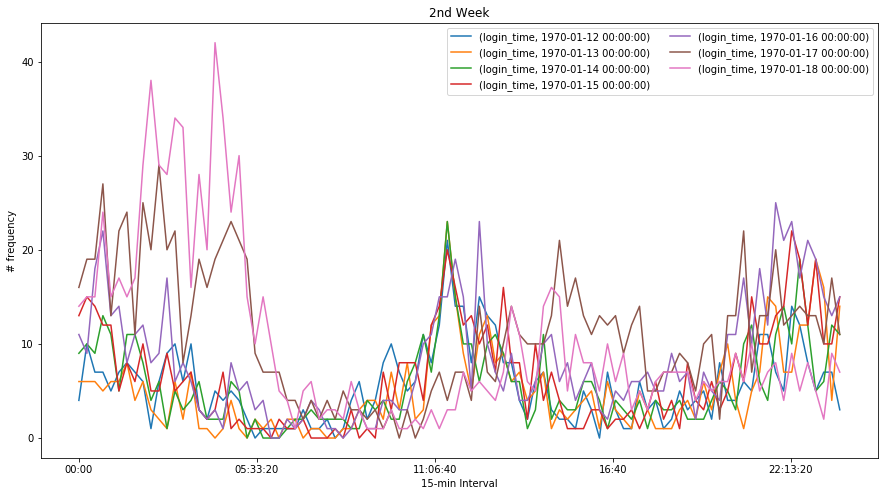

In [94]:
secweek_ = secweek.set_index(['new_time', 'new_date']).unstack()

# Plot the df
fig, ax = plt.subplots(figsize=(15,8))
secweek_.plot(ax=ax, title="2nd Week", legend=False)
ax.set(xlabel="15-min Interval", ylabel="# frequency")

# Customize Legend
ax.legend(loc='upper right', frameon=True, ncol=2)

#### There is a slight difference from the 1st week but overall, the trend is the same. Let's compare the log-in activities by weekday and weekend.

#### Plot weekday

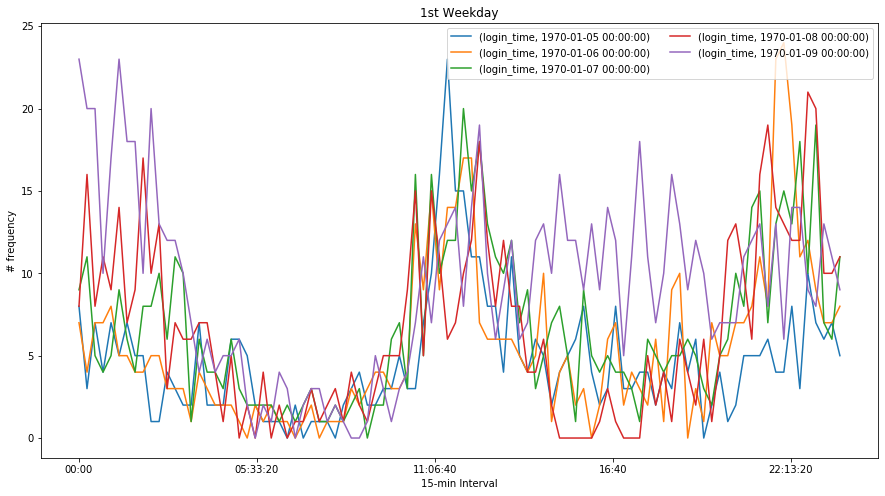

In [16]:
firstweekday = data['1970-01-05':'1970-01-09']


firstweekday_ = firstweekday.set_index(['new_time', 'new_date']).unstack()

# Plot the df
fig, ax = plt.subplots(figsize=(15,8))
firstweekday_.plot(ax=ax, title="1st Weekday", legend=False)
ax.set(xlabel="15-min Interval", ylabel="# frequency")

# Customize Legend
ax.legend(loc='upper right', frameon=True, ncol=2)

#### Looks like there is unsual spike on Friday in the afternoon. 

#### Plot weekend

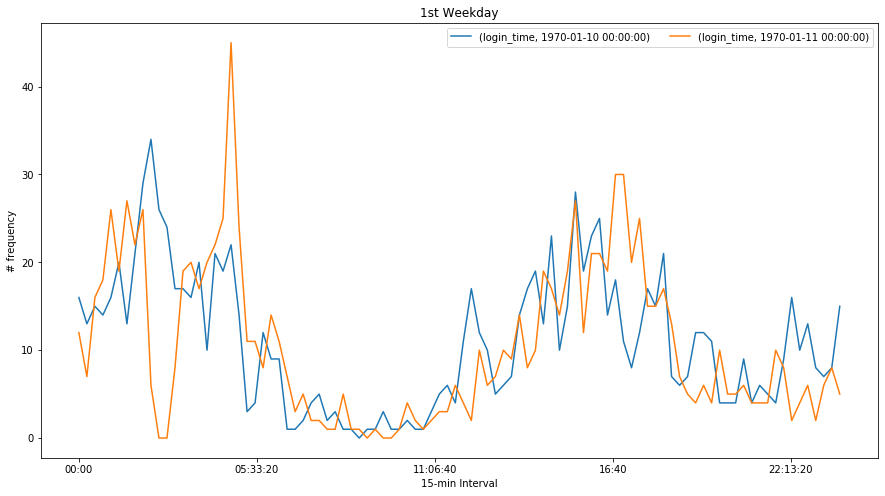

In [17]:
firstweekend = data['1970-01-10':'1970-01-11']

firstweekend_ = firstweekend.set_index(['new_time', 'new_date']).unstack()

# Plot the df
fig, ax = plt.subplots(figsize=(15,8))
firstweekend_.plot(ax=ax, title="1st Weekday", legend=False)
ax.set(xlabel="15-min Interval", ylabel="# frequency")

# Customize Legend
ax.legend(loc='upper right', frameon=True, ncol=2)

### Based on our plots, the log-in activities of the users spike at midday and late nights during the throughout the week. On the weekend, there are unusual trends after midnight.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


Determine whether the number of daily trips increased overall in Ultimate. Also, we need to check whether the number of trips per driver have increased. We need to compare the before and after the experiment whether the number of trips have increase. Since increase might be gradual or it'll take time to get the information about the expirement to the driver, we will get the 3-month data of before anf after the expirement.


The hypothesis would be if reimbursing the toll cost affect the activity of the driver partners. We need to gather the number of trips per driver before and after the experiment. We will have to see if there was a difference and if so, how much? Did it increase, or decrease the number of trips per driver?

To intiate the hypothesis testing, we would need to get the data before and after the experiment. The statistical testing we are going to use is the t-test to compare the values of the means from two samples and test whether it is likely that the samples are from populations having different mean values.

After evaluating the two samples, t-test usually gives us the p-test scores as well. A perfect p-value (and I still don't know why) is 5%. Anything below 5% p-values are good; They indicate your data did not occur by chance. From the t-testm, we can also see the confidence interval, which is the rest of 95% of the data distirbution. If the confidence interval does not contain the null hypothesis value, the results are statistically significant.

# Part 3

### Data Cleaning

In [18]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [19]:
# Convert objects datatypes to float

df2['avg_rating_of_driver'] = df2['avg_rating_of_driver'].astype(float)
df2['avg_rating_by_driver'] = df2['avg_rating_by_driver'].astype(float)

In [20]:
# Convert dates into datetime format

df2['signup_date'] = pd.to_datetime(df2['signup_date'])
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

# TODO: try dropna() for missing rows on avg_rating_of_driver

In [21]:
# Subtract the difference of the dates in months

df2['diff_months'] = (df2.last_trip_date - df2.signup_date) / np.timedelta64(1, 'M')
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff_months
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,4.698248
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,3.154069
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.032855
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,5.585330
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.544180


In [22]:
df2 = df2.fillna(0)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  diff_months             50000 non-null  float6

In [23]:
# Let's categorized users if they were active on their 3rd month since sign-up.
df2['stayed_3mo'] = df2['diff_months'] > 3.0
df2['stayed_6mo'] = df2['diff_months'] > 5.0
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff_months,stayed_3mo,stayed_6mo
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,4.698248,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,3.154069,True,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.032855,False,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,5.585330,True,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.544180,False,False


In [24]:
df2.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,diff_months
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,3.854082,1.074764,8.849536,60.926084,5.796827,4.758950,3.048608
std,3.792684,1.788881,0.222336,19.958811,37.081503,5.707357,0.538617,2.041268
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,0.000000,33.300000,2.420000,4.700000,0.887082
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,3.614037
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,4.928233
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,5.946734


In [25]:
# class distribution
df2.groupby('city').size()

city
Astapor           16534
King's Landing    10130
Winterfell        23336
dtype: int64

In [26]:
# Get the information for those who stayed for 3 months
stayed_3mo = df2.groupby('stayed_3mo')
stayed_3mo.mean()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff_months,stayed_6mo
stayed_3mo,,,,,,,,,,
False,1.659378,3.544926,1.080481,8.832452,0.302380,60.093657,6.385939,4.759673,0.932604,0.00000
True,2.751854,4.090714,1.070388,8.862612,0.434256,61.563234,5.345913,4.758396,4.668223,0.39524


## Data Exploration 
### Plot the numeric data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    50000 non-null  float64
 7   diff_months             50000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB


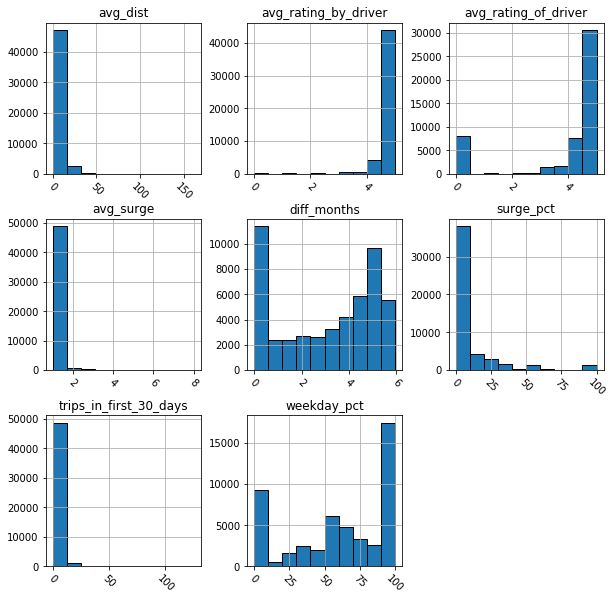

In [27]:
# Plot histogram grid
numeric = df2[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'diff_months']]
numeric.info()
numeric.hist(figsize=(10,10), xrot=-45, edgecolor='black')

# Clear the text "residue"
plt.show()


## Plot the categorical data

In [28]:
# Summarized the data
# Summarize categorical features
df2.describe(include=['object', 'bool'])


,city,phone,ultimate_black_user,stayed_3mo,stayed_6mo
count,50000,50000,50000,50000,50000
unique,3,3,2,2,2
top,Winterfell,iPhone,False,True,False
freq,23336,34582,31146,28322,38806


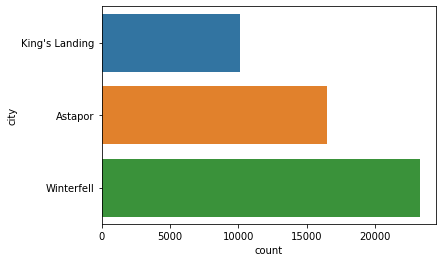

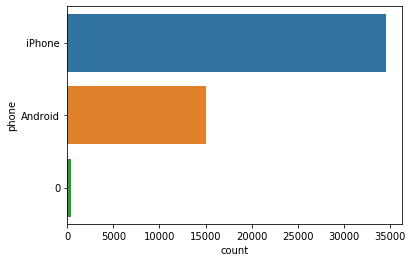

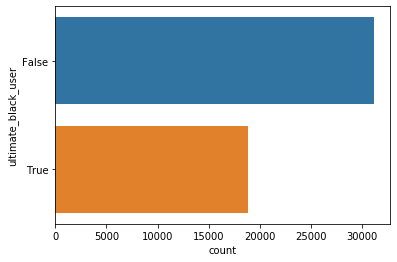

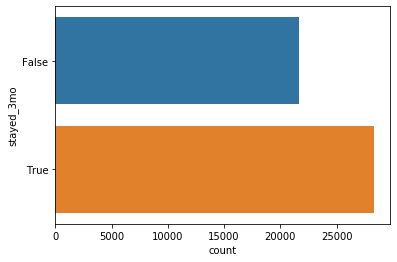

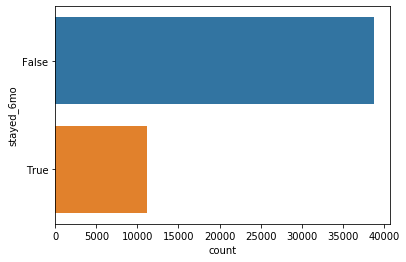

In [29]:
#Plot bar plot for each categorical feature
categorical_features = df2.select_dtypes(include=['object', 'bool']).columns.tolist()

for cat_feat in categorical_features:
    sns.countplot(y = cat_feat, data=df2)
    plt.show()



In [30]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff_months,stayed_3mo,stayed_6mo
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,4.698248,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,3.154069,True,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.032855,False,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,5.585330,True,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.544180,False,False


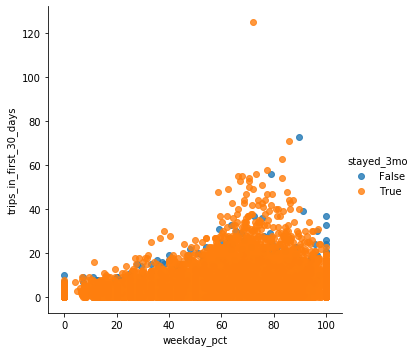

In [31]:
# Scatterplot of avg_rating_of_driver vs. trips_in_first_30_days
sns.lmplot(y='trips_in_first_30_days', x = 'weekday_pct', data=df2, hue='stayed_3mo', fit_reg=False)
plt.show()



### Looks like users that stayed for 3 months have more trips in their first 30 days , higher rating, 

### Plot the correllation between all features

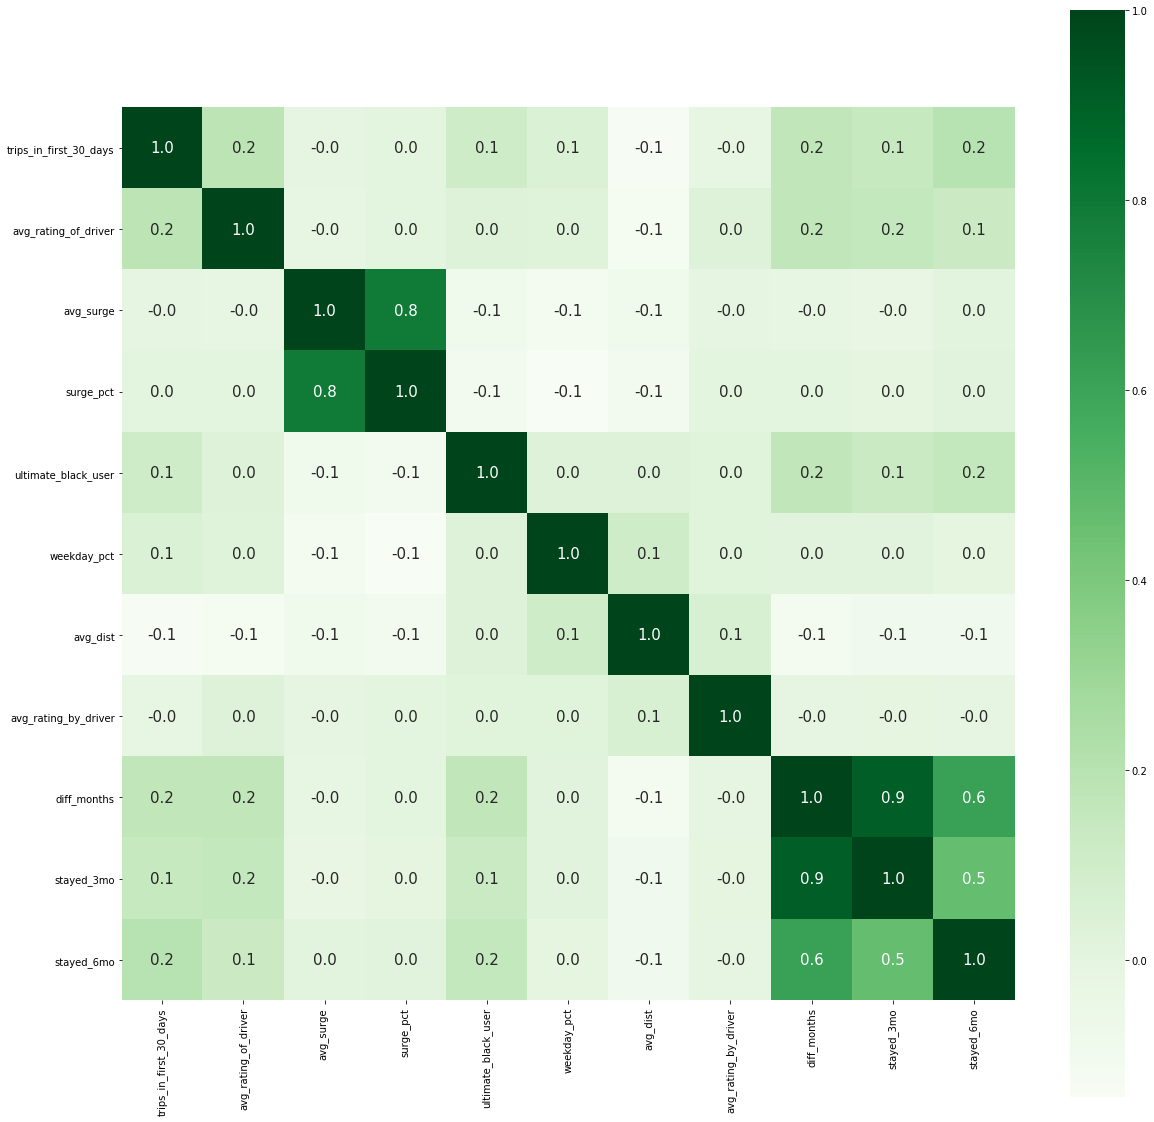

In [32]:
# Plotting the heatmap of correlation between features
corr = df2.corr()
corr.shape

plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')
plt.show()


## Feature Engineering
Data processing for machine learning part

### One-hot encode categorical variables

In [33]:
# One hot encode the categorical city variables
df_ohe = pd.get_dummies(df2, columns=['city', 'phone', 'ultimate_black_user'])

# We will drop the datetime as this is not needed for training and testing (and won't pass in our models)
df_ohe = df_ohe.drop(['signup_date', 'last_trip_date', 'diff_months', ], axis=1)


### Feature Selection

In [34]:
features = [
            'trips_in_first_30_days', 
            'avg_rating_of_driver', 
            'avg_surge',
            'surge_pct', 
            'weekday_pct', 
            'avg_dist',
            'avg_rating_by_driver',
            'city_Astapor',
            "city_King's Landing",
            'city_Winterfell',
            'phone_0',
            'phone_Android',
            'phone_iPhone',
            'ultimate_black_user_False',
            'ultimate_black_user_True'
           ]


In [35]:
# Create separate object for target variable
y = df_ohe['stayed_3mo']

# Create separate object for input features
X = df_ohe[features]
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_0,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,100.0,5.63,4.2,0,1,0,0,0,1,1,0
49996,1,0.0,1.00,0.0,0.0,0.00,4.0,1,0,0,0,0,1,1,0
49997,0,5.0,1.00,0.0,100.0,3.86,5.0,0,0,1,0,1,0,0,1
49998,2,3.0,1.00,0.0,100.0,4.58,3.5,1,0,0,0,0,1,1,0


## Create Train and Test set


In [36]:
# Split-out validation dataset using stratified random sampling


# Split X and y into train and test sets
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size = 0.2,
                                                     random_state = 1234, 
                                                     stratify = df_ohe.stayed_3mo)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

40000 10000
40000 10000


## Classification Models (Not hypertuned)

We will be trying these models: 
 - Logistic Regression
 - Decision Trees
 - Random Forest
 - Gaussian Naive Bayes

### Logistic Regression

In [37]:
# Create a Logistic regression classifier
logreg = LogisticRegression()

# Train the model using the training sets 
logreg.fit(X_train, y_train)

# Prediction on test data
y_pred = logreg.predict(X_test)

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
# Calculating the accuracy of Vanilla Logistic Regression
acc_logreg = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of Logistic Regression model : ', acc_logreg )

Accuracy of Logistic Regression model :  63.43


### Gaussian Naive Bayes

In [39]:
# Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(X_train,y_train)

# Prediction on test set
y_pred = model.predict(X_test)

In [40]:
# Calculating the accuracy of Gaussian Naive Bayes
acc_nb = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of Gaussian Naive Bayes model : ', acc_nb )

Accuracy of Gaussian Naive Bayes model :  65.07


### Random Forest

In [41]:
# Create a Random Forest Classifier
rfc = RandomForestClassifier()

# Train the model using the training sets 
rfc.fit(X_train,y_train)

# Prediction on test set
y_pred = rfc.predict(X_test)


In [42]:
# Calculating the accuracy of RandomForestClassifier
acc_rfc = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of RandomForestClassifier model : ', acc_rfc )

Accuracy of RandomForestClassifier model :  75.35


### Decision Tree Classifier

In [43]:
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create a Decision tree classifier model
clf = DecisionTreeClassifier()

# Train the model using the training sets 
clf.fit(X_train,y_train)

# Prediction on test set
y_pred = clf.predict(X_test)

In [44]:
# Calculating the accuracy of DecisionTreeClassifier
acc_dt = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of DecisionTreeClassifier model : ', acc_dt )

Accuracy of DecisionTreeClassifier model :  70.87


### Evaluate Accuracy Scores

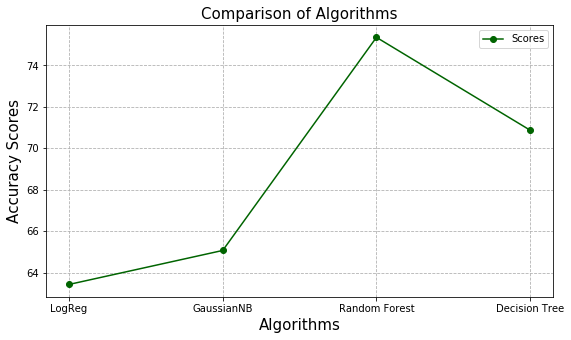

In [45]:
x_algo = ['LogReg', 'GaussianNB', 'Random Forest', 'Decision Tree']
all_algos_cv = [acc_logreg, acc_nb, acc_rfc, acc_dt]

acc_scores = [round(res, 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Vanilla Algorithms', loc='center', fontsize=15)
plt.plot(x_algo, acc_scores, label='Scores', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Accuracy Scores', fontsize=15)
plt.legend()
plt.grid(ls='dashed')


## Classification Models Hyperparameter Tuning

### Logistic Regression

In [60]:
# Create a Random Forest Classifier
lr = LogisticRegression()

# Hyperparameter Optimization
parameters = {'penalty': ['l1','l2'], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
              'C': np.logspace(0, 4, 10)
             }

# Run the grid search
grid_obj = GridSearchCV(lr, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf to the best combination of parameters
lr = grid_obj.best_estimator_
lr_best_estimator = grid_obj.best_estimator_

# Train the model using the training sets 
lr.fit(X_train,y_train)


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFaile

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: T

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: T

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: T

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/op

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: T

LogisticRegression(C=2.7825594022071245)

In [61]:
# Prediction on test data
y_pred = lr.predict(X_test)

# Calculating the accuracy
acc_logreg = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of Logistic Regression model : ', acc_logreg )


Accuracy of Logistic Regression model :  63.4


### Random Forest 

In [62]:
# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf to the best combination of parameters
rf = grid_obj.best_estimator_
rf_best_estimator = grid_obj.best_estimator_

# Train the model using the training sets 
rf.fit(X_train,y_train)

# Prediction on test data
y_pred = rf.predict(X_test)


In [63]:
# Calculating the accuracy
acc_rf = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of RandomForestClassifier model : ', acc_rf )


Accuracy of RandomForestClassifier model :  77.44


### Decision Tree

In [64]:
# Create a Decision tree classifier model
dt = DecisionTreeClassifier()

# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }

# Run the grid search
grid_obj = GridSearchCV(dt, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dt = grid_obj.best_estimator_
dt_best_estimator = grid_obj.best_estimator_


# Train the model using the training sets 
dt.fit(X_train, y_train)

# Prediction on test data
y_pred = dt.predict(X_test)


In [65]:
# Calculating the accuracy
acc_dt = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of DecisionTreeClassifier model : ', acc_dt )


Accuracy of DecisionTreeClassifier model :  74.62


### Print out accuracy scores of Hypertuned models

In [66]:
print('Hypertuned Random Forest Accuracy', acc_rf)
print('Hypertuned Random Forest Best Estimator', rf_best_estimator)

print('Hypertuned Logistic Regression Accuracy', acc_logreg)
print('Hypertuned Logistic Regression Best Estimator', lr_best_estimator)

print('Hypertuned Decision Tree¶ Accuracy', acc_dt)
print('Hypertuned Decision Tree¶ Best Estimator', dt_best_estimator)


Hypertuned Random Forest Accuracy 77.44
Hypertuned Random Forest Best Estimator RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=15)
Hypertuned Logistic Regression Accuracy 63.4
Hypertuned Logistic Regression Best Estimator LogisticRegression(C=2.7825594022071245)
Hypertuned Decision Tree¶ Accuracy 74.62
Hypertuned Decision Tree¶ Best Estimator DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       min_samples_split=50)


#### Random forest got the highest accuracy score from the models we hypertuned. We are going to fit the model, with the best paramaters into out test set.

## Test the final model

In [71]:
model = RandomForestClassifier(max_depth=10,
                               max_features='sqrt',
                               min_samples_leaf=5,
                               min_samples_split=5,
                               n_estimators=15)

# Train the model using the training sets 
model.fit(X_train, y_train)

# Print out the test and train scores of the model
print('Accuracy score of the model from train set:', model.score(X_train, y_train))
print('Accuracy score of the model from test set:', model.score(X_test, y_test))



Accuracy score of the model from train set: 0.790375
Accuracy score of the model from test set: 0.7705


## Get the prediction from the model

In [82]:
y_predict = model.predict_proba(X)
y_predict[:10]

array([[0.02636603, 0.97363397],
       [0.44909672, 0.55090328],
       [0.8180573 , 0.1819427 ],
       [0.0225216 , 0.9774784 ],
       [0.22888349, 0.77111651],
       [0.66172499, 0.33827501],
       [0.81981411, 0.18018589],
       [0.83867033, 0.16132967],
       [0.83249683, 0.16750317],
       [0.911325  , 0.088675  ]])

In [91]:
y

0         True
1         True
2        False
3         True
4        False
         ...  
49995     True
49996    False
49997     True
49998    False
49999     True
Name: stayed_3mo, Length: 50000, dtype: bool